In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.fft as npf
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools as im

from IPython.display import clear_output

# 1

In [ ]:
class Identity(LinearOperator):
    '''
    Implements the identity operator encapsulated as a class
    '''
    def __call__(self, x):
        '''
        Calls Idenetity class as operator
        Args:
            x:input image
        Returns:
            copy of x
        '''
        assert x.shape == self.ishape
        return x.copy()
        
    def adjoint(self,x):
        '''
        Returns operation of adjoint of identity operation on input x
        Args:
            x: input to the operator
        Returns:
            copy of x
        '''
        assert x.shape == self.ishape
        return x.copy()
    
    def gram(self,x):
        '''
        Returns operation of gram operation on input x
        Args:
            x: input to the operator
        Returns:
            copy of x
        '''
        assert x.shape == self.ishape
        return x.copy()

    def gram_resolvent(self,x,tau):
        '''
         
        Returns operation of  of idegramntity operation on input x
        Args:
            x: input to the operator
            tau: scaling offered to matrix
        Returns:
            copy of x      
        '''
        res = x.copy()/(1 + tau)
        return res 

# 2

In [ ]:
class Convolution(LinearOperator):
    '''
    Implements the convolution operator encapsulated as a class
    '''
    def __init__(self,ishape, nu, separable=None):
        '''
        Initializes the convolution as an operator encapsulated as a class
        Args:
            self: pointer to current instance of the class
            shape: shape of the input 
            nu: kernel to convolve input with
        Kwargs:
            separable: indicates nature of separabiity
        '''
        #self.ishape = shape
        if separable:
            assert isinstance(separable,str)
            assert separable in ("product","sum")
        self.n1,self.n2 = ishape[:2]
        self.lbd = kernel2fft(nu,self.n1,self.n2,separable=separable)
        self.adj_lbd = np.conjugate(self.lbd)

    def __call__(self,x):
        '''
        Computes convolution of x with a kernel of frequency response lbd
        Args:
            x : input image
        Returns:
            y : output of convolution
        '''
        #assert x.shape == self.ishape
        return convolvefft(x,self.lbd)

    def adjoint(self,x):
        '''
        Computes the adjoint of the convolution with kernel nu
        Args:
            x: input to convolution operator
        Returns:
            y : output of convolution
        '''
        return convolvefft(x,self.adj_lbd)
    
    def gram(self,x):
        '''
        Returns gram of convolution operation
        Args:
            x: input to operation
        Returns:
            gram operation of kernel
        '''
        #assert x.shape == self.ishape
        return convolvefft(x,self.lbd*self.adj_lbd)

    def gram_resolvent(self,x,tau):
        '''
        Args:
            x: input to the operator
            tau: scaling offered to matrix
        Returns:
            copy of x      
        '''
        #assert x.shape == self.ishape
        return cg(lambda z: z + tau * self.gram(z), x)

# 3

In [ ]:
class RandomMasking(LinearOperator):
    def __init__(self,ishape,p):
        '''
        Initializes matrix for Random Masking
        Args:
            self: pointer to current instance of the class
            ishape: shape of input
            p: percentage of masking
        '''
        self.kernel = np.random.choice([0,1],size=ishape,p=[p,1-p])
    
    def __call__(self,x):
        '''
        Computes random masking of x 
        Args:
            x : input image
        Returns:
            y : output of random masking
        '''
        #assert x.shape == self.ishape
        return x*self.kernel

    def adjoint(self,x):
        '''
        Computes the adjoint of the random masking with kernel nu
        Args:
            x: input to convolution operator
        Returns:
            y : output of convolution
        '''
        #assert x.shape == self.ishape
        return x*self.kernel 

    def gram(self,x):
        '''
        Returns gram of random masking operation
        Args:
            x: input to operation
        Returns:
            gram operation of kernel
        '''
        #assert x.shape == self.ishape
        return x*self.kernel 

    def gram_resolvent(self,x,tau):
        '''
        Args:
            x: input to the operator
            tau: scaling offered to matrix
        Returns:
            copy of x  
        '''
        #assert x.shape == self.ishape
        return cg(lambda z: z + tau * self.gram(z), x)

# 4

In [2]:
x = plt.imread('assets/starfish.png')

In [3]:
y = plt.imread('assets/topgun.png')

Text(0.5, 1.0, 'Random masking')

/Users/eseetao/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


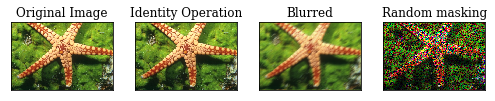

In [4]:
random_masking = im.RandomMasking(x.shape,0.4)
identity = im.Identity(x.shape)
motion_blur = im.Convolution(x.shape,im.kernel("motion"))

fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(7,15))
axes[0].imshow(x)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Original Image")

axes[1].imshow(identity(x))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("Identity Operation")

axes[2].imshow(motion_blur(x))
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title("Blurred")

axes[3].imshow(random_masking(x))
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[3].set_title("Random masking")

# 5

In [5]:
def matrix_product(x,y):
    '''
    computes matrix dot product
    '''
    return np.sum(x*y)

## Random Masking

In [6]:
print("Comparison of matrix products <Hx,y> and <x,H*y> returns {}".format(np.allclose(matrix_product(random_masking(x),y),matrix_product(x,random_masking.adjoint(y)))))

Comparison of matrix products <Hx,y> and <x,H*y> returns True


## Identity

In [7]:
print("Comparison of matrix products <Hx,y> and <x,H*y> returns {}".format(np.allclose(matrix_product(identity(x),y),matrix_product(x,identity.adjoint(y)))))

Comparison of matrix products <Hx,y> and <x,H*y> returns True


## Convolution

In [8]:
print("Comparison of matrix products <Hx,y> and <x,H*y> returns {}".format(np.allclose(matrix_product(motion_blur(x),y),matrix_product(x,motion_blur.adjoint(y)))))

Comparison of matrix products <Hx,y> and <x,H*y> returns True


# 6

In [9]:
def inv_gram_res(obj,x,tau):
    '''
    Computes inverse of gram resolvent matrix
    Args:
        obj: operation
        x: input image
        tau: constant of regularization
    Returns:
        inverse of gram resolvent
    '''
    return x + (tau*obj.adjoint(obj(x)))

## Identity

In [10]:
confirm = identity.gram_resolvent(inv_gram_res(identity,x,2),2)
print("Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is {0}".format(np.allclose(confirm,x)))

Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is True


## Random Masking

In [11]:
confirm = random_masking.gram_resolvent(inv_gram_res(random_masking,x,2),2)
print("Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is {}".format(np.allclose(confirm,x)))

Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is True


## Motion Blur

In [12]:
confirm = motion_blur.gram_resolvent(inv_gram_res(motion_blur,x,2),2)
print("Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is {}".format(np.allclose(confirm,x,atol=1e-2)))

Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is True


# 7

In [13]:
def dwt(x,J,h,g):
    '''
    Computes the discrete wavelet transform
    Args:
        x: input image
        J: number of scales at which the wavelet transform is computed
        h: high pass filter used 
        g: lowpass filter used
    Returns:
        z : dwt coefficients
    '''
    if J == 0:
        return x
    n1, n2 = x.shape[:2]
    m1, m2 = (int(n1 / 2), int(n2 / 2))
    z = dwt1d(x, h, g)
    z = np.rot90(dwt1d(np.rot90(z,k=3), h, g),k=1)
    z[:m1, :m2] = dwt(z[:m1, :m2], J - 1, h, g)
    return z

def dwt1d(x, h, g): # 1d and 1scale
    '''
    compute 1D wavelet transform
    Args:
        x: input image
        h:high pass filter
        g:low pass filter
    Returns:
        z:dwt coefficients
    '''
    coarse = convolve(x, g)
    detail = convolve(x, h)
    z = np.concatenate((coarse[::2, :], detail[::2, :]), axis=0)
    return z

# 8 

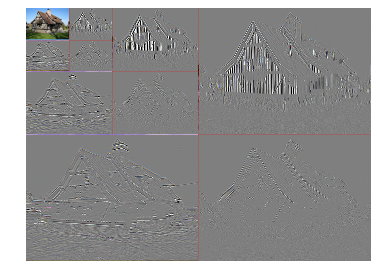

In [14]:
x0 = plt.imread("assets/normandy.png")
J = 3
h,g = im.wavelet('db2')
y0 = im.dwt(im.dwt_crop(x0,J),J,h,g)
im.showdwt(y0,J=3)

# 9

In [15]:
def idwt(z, J, h, g): # 2d and multi-scale
    '''
    Implement 2D inverse DWT
    Args:
        z: DWT wavelet transform image
        J: scales
        h: filter h
        g: filter g
    '''
    if J == 0:
        return z
    n1, n2 = z.shape[:2]
    m1, m2 = (int(n1 / 2), int(n2 / 2))
    x = z.copy()
    x[:m1, :m2] = idwt(x[:m1, :m2], J - 1, h, g)
    x = np.rot90(idwt1d(np.rot90(x,k=3), h, g),k=1)
    x = idwt1d(x, h, g)
    return x

def idwt1d(z, h, g): # 1d and 1scale
    '''
    Implement 1D inverse DWT
    Args:
        z: DWT wavelet transform image
        h: filter h
        g: filter g
    '''
    n1 = z.shape[0]
    m1 = int(n1 / 2)
    coarse, detail = np.zeros(z.shape), np.zeros(z.shape)
    coarse[::2, :], detail[::2, :] = z[:m1, :], z[m1:, :]
    x = convolve(coarse, g[::-1]) + convolve(detail, h[::-1])
    return x 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


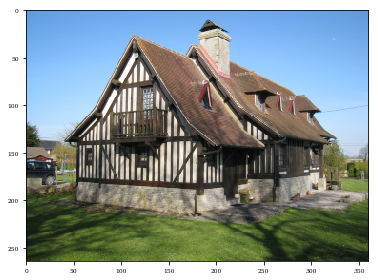

In [16]:
x = im.idwt(y0,J,h,g)
plt.imshow(x)

# 10

In [17]:
confirm = im.dwt(im.idwt(y0,J,h,g),J,h,g)
print("Confirm if dwt is left inverse idwt of {}".format(np.allclose(confirm,y0)))

Confirm if dwt is left inverse idwt of True


In [18]:
confirm = im.idwt(im.dwt(im.dwt_crop(x0,J),J,h,g),J,h,g)
print("Confirm if idwt is left inverse dwt of {}".format(np.allclose(confirm,im.dwt_crop(x0,J))))

Confirm if idwt is left inverse dwt of True


In [19]:
x=im.dwt_crop(plt.imread('assets/starfish.png'),J)
y =im.dwt_crop(plt.imread('assets/topgun.png'),J)
print("Confirm that idwt in adjoint of dwt {}".format(np.allclose(matrix_product(im.dwt(x,J,h,g),y),matrix_product(x,im.idwt(y,J,h,g)))))

Confirm that idwt in adjoint of dwt True


# 11

In [ ]:
class DWT(LinearOperator):
    def __init__(self,ishape,J,name="db2"):
        '''
        Initializes op for DWT transform encalsulated as a class
        Args:
            shape : shape of input provided
            J: number of scales at which the op is carried out
        Kwargs:
            name:name of wavelet used
        '''
        self.shape = ishape
        self.h,self.g = wavelet(name) 
        self.J = J

    def __call__(self,x):
        '''
        Calls DWT class as operator
        Args:
            x:input image
        Returns:
            dwt of x
        '''
        return dwt(x,self.J,self.h,self.g)

    def adjoint(self,x):
        '''
        Returns operation of adjoint of DWT operation on input x
        Args:
            x: input to the operator
        Returns:
            adjoint of x
        '''
        return idwt(x,self.J,self.h,self.g)

    def gram(self,x):
        '''
        Returns operation of gram operation on input x
        Args:
            x: input to the operator
        Returns:
            gram of x
        '''
        return idwt(dwt(x,self.J,self.h,self.g),self.J,self.h,self.g)

    def gram_resolvent(self,x,tau):
        '''
        Returns operation of gram resolvent operation on input x with kernel tau
        Args:
            x: input to the operator
            tau: scaling offered to matrix
        Returns:
            gram resolvent of x
        '''
        return cg(lambda z: z + tau * self.gram(z), x)

    def invert(self,x):
        '''
        Returns operation of inversion on input x
        Args:
            x: input to the operator
        Returns:
            inversion of x
        '''
        return idwt(x,self.J,self.h,self.g)

    def power(self):
        '''
        Returns power operation
        '''
        return dwt_power(self.shape[0],self.shape[1],len(self.shape))

# 12

In [20]:
def softthresh(z,t):
    '''
    Implements soft thresholding of matrix z with threshold t
    Args:
        z: array
        t: threshold
    Returns:
        threshold: thresholded version of z
    '''
    
    threshold = np.maximum(z-t,np.zeros_like(z))+np.minimum(z+t,np.zeros_like(z))
    
    return threshold

## 13

In [21]:
def softthresh_denoise(y, sig, W, alpha=10/255):
    '''
    Removes noise by performing soft-thresholding on the wavelet coefficients
    Args:
        y: image
        sig: standard deviation
        W: wavelet transformation
    Kwargs:
        alpha: scaling factor
    Returns:
        Denoised image
    '''
    
    coeff = W(y)
    tau = np.sqrt(2)*np.square(sig)/(alpha*W.power())
    return softthresh(coeff,tau)

# 14

In [22]:
J=3
clean = im.dwt_crop(plt.imread("assets/dragonfly.png"),J)
W = im.DWT(clean.shape,J)
sig = 20 / 255
noisy = clean + sig * np.random.randn(*clean.shape)
#psnr = [im.psnr(clean,W.invert(softthresh_denoise(noisy, sig, W, alpha=i/255))) for i in [6/255, 8/255, 10/255, 12/255,16/255,20/255]]
psnr = [im.psnr(clean,W.invert(softthresh_denoise(noisy, sig, W, alpha=i/255))) for i in range(3,20)]

Text(0.5, 0, 'alpha')

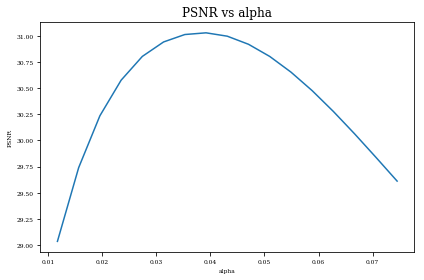

In [23]:
plt.plot([i/255 for i in range(3,20)],psnr)
plt.title("PSNR vs alpha")
plt.ylabel("PSNR")
plt.xlabel("alpha")

# 15 & 17

In [24]:
def interleave0(x):
    '''
    Upsample the filters h and g in udwt by injecting 2^(j − 1) zeros between each entries.
    Args:
        x: input vector
        j: interleaving factor
    Returns:
        x1: interleaved vector
    '''
    x1=np.zeros(((x.shape[0]-1)*2+1,1))
    x1[::2,:]=x
    return x1


def udwt(x, J, h, g):
    '''
    Implements the 2d Undecimated Discrete Wavelet Transform (UDWT) with J scales
    Args:
        x: image
        J: scales
        h: filter h
        g: filter g
    Returns:
        z: udwt transformation
    '''
    if J == 0:
        return x[:, :, None]
    tmph = np.rot90(im.convolve(np.rot90(x,k=3), h),k=1) / 2
    tmpg = np.rot90(im.convolve(np.rot90(x,k=3), g),k=1) / 2     
    z = np.stack((im.convolve(tmpg, h),im.convolve(tmph, g),im.convolve(tmph, h)), axis=2)
    coarse = im.convolve(tmpg, g)
    h2 = interleave0(h)
    g2 = interleave0(g)
    z = np.concatenate((udwt(coarse, J - 1, h2, g2), z),axis=2)
    return z

def iudwt(z, J, h, g):
    '''
    Implements the 2d Inverse UDWT
    Args:
        z: input img
        J: scales
        h: filter h
        g: filter g
    Returns:
        x: the 2D inverse UDWT
    '''
    if J == 0:
        return z[:, :, 0]
    h2 = interleave0(h)
    g2 = interleave0(g)
    coarse = iudwt(z[:, :, :-3], J - 1, h2, g2)
    tmpg = im.convolve(coarse, g[::-1]) + im.convolve(z[:, :, -3], h[::-1])
    tmph = im.convolve(z[:, :, -2], g[::-1]) + im.convolve(z[:, :, -1], h[::-1])
    x = (np.rot90(im.convolve(np.rot90(tmpg,k=3), g[::-1]),k=1) + np.rot90(im.convolve(np.rot90(tmph,k=3), h[::-1]),k=1)) / 2
    return x

In [25]:
x0 = plt.imread("assets/dragonfly.png")
source = im.dwt_crop(x0,J)
undec_wavelet = udwt(source,J,h,g)
inverse = iudwt(undec_wavelet,J,h,g)
reverse = udwt(iudwt(undec_wavelet,J,h,g),J,h,g)

## 16

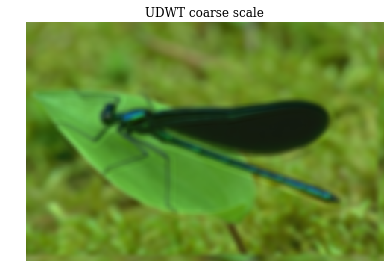

In [26]:
im.show(undec_wavelet[:,:,0,:])
plt.title("UDWT coarse scale")
plt.show()

Text(0.5, 1.0, 'Detailed Scale #6')

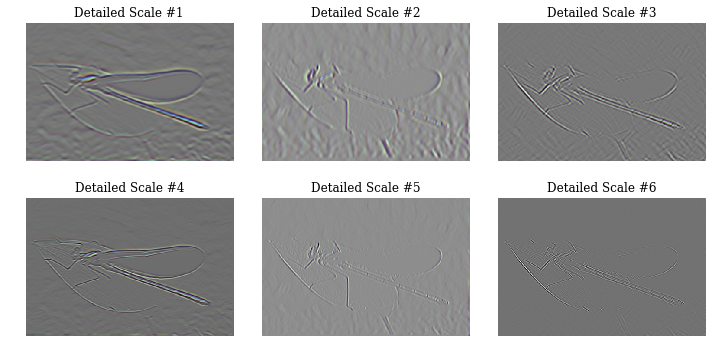

In [27]:
fig,axes= plt.subplots(nrows=2,ncols=3,figsize=(10,5))
im.show(undec_wavelet[:,:,1,:],vmin=np.min(undec_wavelet[:,:,1,:]),vmax=np.max(undec_wavelet[:,:,1,:]),ax=axes[0][0])
axes[0][0].set_title("Detailed Scale #1")
im.show(undec_wavelet[:,:,2,:],vmin=np.min(undec_wavelet[:,:,2,:]),vmax=np.max(undec_wavelet[:,:,2,:]),ax=axes[0][1])
axes[0][1].set_title("Detailed Scale #2")
im.show(undec_wavelet[:,:,3,:],vmin=np.min(undec_wavelet[:,:,3,:]),vmax=np.max(undec_wavelet[:,:,3,:]),ax=axes[0][2])
axes[0][2].set_title("Detailed Scale #3")
im.show(undec_wavelet[:,:,4,:],vmin=np.min(undec_wavelet[:,:,4,:]),vmax=np.max(undec_wavelet[:,:,4,:]),ax=axes[1][0])
axes[1][0].set_title("Detailed Scale #4")
im.show(undec_wavelet[:,:,5,:],vmin=np.min(undec_wavelet[:,:,5,:]),vmax=np.max(undec_wavelet[:,:,5,:]),ax=axes[1][1])
axes[1][1].set_title("Detailed Scale #5")
im.show(undec_wavelet[:,:,6,:],vmin=np.min(undec_wavelet[:,:,6,:]),vmax=np.max(undec_wavelet[:,:,6,:]),ax=axes[1][2])
axes[1][2].set_title("Detailed Scale #6")

## 18

In [28]:
print("Checking udwt and iudwt are left invert of each other",np.allclose(source,inverse))
print("Checking udwt and iudwt are right invert of each other",np.allclose(reverse,undec_wavelet))

Checking udwt and iudwt are left invert of each other True
Checking udwt and iudwt are right invert of each other False


UDWT and IUDWT operates in different dimensions, as such they cannot be adjoints of each other. UDWT is invertible but IUDWT is not invertible. Since the UDWT operator is not square, it is not invert

# 19

In [29]:
def udwt_create_fb(n1, n2, J, h, g, ndim=3):
    '''
    Implements UDWT with filter bank
    Args:
        n1: kernel dim n
        n2: kernel dim m
        J: scales
        h: filter h
        g: filter g
    Kwargs:
        ndim: number of dimensions
    Returns:
        fb: filter bank
    '''
    
    if J == 0:
        return np.ones((n1, n2, 1, *[1] * (ndim - 2)))
    h2 = interleave0(h)
    g2 = interleave0(g)
    fbrec = udwt_create_fb(n1, n2, J - 1, h2, g2, ndim=ndim)
    gf1 = nf.fft(fftpad(g, n1), axis=0)
    hf1 = nf.fft(fftpad(h, n1), axis=0)
    gf2 = nf.fft(fftpad(g, n2), axis=0)
    hf2 = nf.fft(fftpad(h, n2), axis=0)
    fb = np.zeros((n1, n2, 4), dtype=np.complex128)
    fb[:, :, 0] = np.outer(gf1, gf2) / 2
    fb[:, :, 1] = np.outer(gf1, hf2) / 2
    fb[:, :, 2] = np.outer(hf1, gf2) / 2
    fb[:, :, 3] = np.outer(hf1, hf2) / 2
    fb = fb.reshape(n1, n2, 4, *[1] * (ndim - 2))
    fb = np.concatenate((fb[:, :, 0:1] * fbrec, fb[:, :, -3:]),axis=2)
    return fb

def fb_apply(x, fb):
    '''
    Application of filter bank
    Args:
        x: image 
        fb: filter bank
    Returns:
        z: applied filter bank
    '''
    
    x = nf.fft2(x, axes=(0, 1))
    z = fb * x[:, :, np.newaxis]
    z = np.real(nf.ifft2(z, axes=(0, 1)))
    return z

def fb_adjoint(z, fb):
    '''
    Application of adjoint filter bank
    Args:
        z: input img
        fb: filter bank
    Returns:
        x: adjoint filter bank
    '''
    
    z = nf.fft2(z, axes=(0, 1))
    x = (np.conj(fb) * z).sum(axis=2)
    x = np.real(nf.ifft2(x, axes=(0, 1)))
    return x

# 20

In [ ]:
class UDWT(LinearOperator):
    def __init__(self,ishape,J,name="db2",using_fb=True):
        '''
        Initializes op for DWT transform encalsulated as a class
        Args:
            shape : shape of input provided
            J: number of scales at which the op is carried out
        Kwargs:
            name:name of wavelet used
        '''
        self.shape = ishape
        self.h,self.g = wavelet(name) 
        self.ah,self.ag = adjoint(self.h),adjoint(self.g)
        self.mode = using_fb
        self.J = J
        if self.mode:
            self.fb = udwt_create_fb(self.shape[0], self.shape[1], self.J, self.h, self.g, ndim=3)
        else:
            self.fb = None
            

    def __call__(self,x):
        '''
        Computes UDWT
        Args:
            x : input image
        '''
        if self.mode:
            return fb_apply(x,self.fb)
        else:
            return udwt(x,self.J,self.h,self.g)

    def adjoint(self,x):
        '''
        Computes the adjoint of the UDWT 
        Args:
            x: input to UDWT operator
        '''
        if self.mode:
            return fb_adjoint(x,self.fb)
        else:
            return iudwt(x,self.J,self.h,self.g)

    def gram(self,x):
        '''
        Computes gram of the UDWT
        Args:
            x: input to UDWT operator
        '''
        return self.adjoint(self.__call__(x))

    def gram_resolvent(self,x,tau):
        '''
        Computes gram resolvent of UDWT with scaling tau
        Args:
            x: input to the UDWT operator
            tau: scaling offered to matrix
        '''
        return cg(lambda z: z + tau * self.gram(z), x)

    def invert(self,x):
        '''
        Computes inversion of UDWT
        Args:
            x: input to the UDWT operator
        '''
        return self.adjoint(x)

    def power(self):
        '''
        Computes power of UDWT
        '''
        return udwt_power(self.J)

## 21

Text(0.5, 1.0, 'Soft thresholding PSNR:32.43')

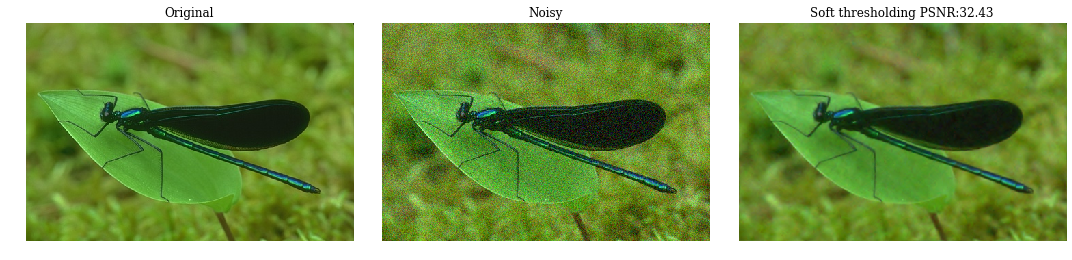

In [30]:
x0 = plt.imread("assets/dragonfly.png")
clean = im.dwt_crop(x0,J)
W = im.UDWT(clean.shape,J)
sig = 20 / 255
noisy = clean + sig * np.random.randn(*clean.shape)
start = time.time()
UDWT_soft_thresh = W.invert(softthresh_denoise(noisy,20/255,W))
end = time.time()

fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(15,7))
im.show(clean,ax=axes[0])
axes[0].set_title("Original")
im.show(noisy,ax=axes[1])
axes[1].set_title("Noisy")
im.show(UDWT_soft_thresh,ax=axes[2])
axes[2].set_title("Soft thresholding PSNR:{}".format(np.round(im.psnr(clean,UDWT_soft_thresh),decimals=2)))

In [31]:
print("Time taken for filter bank implementation {}".format(end-start))

Time taken for filter bank implementation 1.0919160842895508


Text(0.5, 1.0, 'Soft thresholding PSNR:32.44')

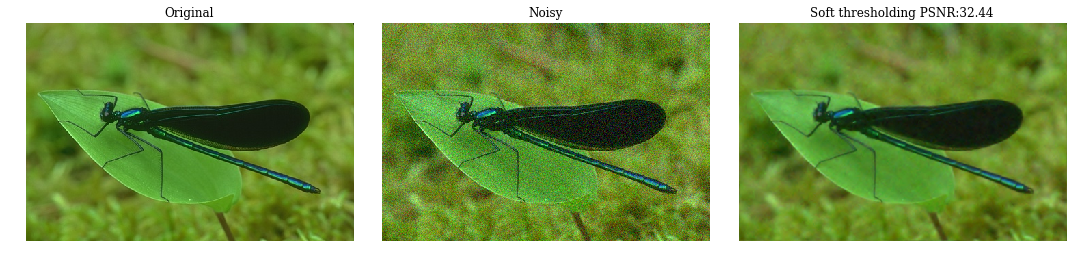

In [32]:
x0 = plt.imread("assets/dragonfly.png")
clean = im.dwt_crop(x0,J)
W = im.UDWT(clean.shape,J,using_fb=False)
sig = 20 / 255
noisy = clean + sig * np.random.randn(*clean.shape)
start = time.time()
UDWT_soft_thresh = W.invert(softthresh_denoise(noisy,20/255,W))
end = time.time()

fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(15,7))
im.show(clean,ax=axes[0])
axes[0].set_title("Original")
im.show(noisy,ax=axes[1])
axes[1].set_title("Noisy")
im.show(UDWT_soft_thresh,ax=axes[2])
axes[2].set_title("Soft thresholding PSNR:{}".format(np.round(im.psnr(clean,UDWT_soft_thresh),decimals=2)))

In [33]:
print("Time taken for naive implementation {}".format(end-start))

Time taken for naive implementation 5.510089874267578


Text(0.5, 1.0, 'Soft thresholding PSNR:31.02')

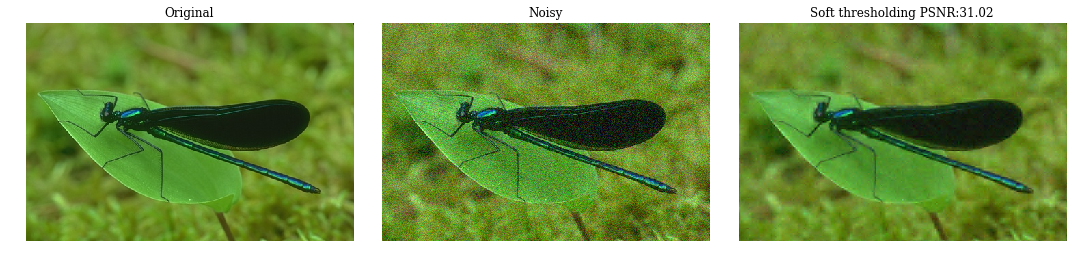

In [34]:
x0 = plt.imread("assets/dragonfly.png")
clean = im.dwt_crop(x0,J)
W = im.DWT(clean.shape,J)
sig = 20 / 255
noisy = clean + sig * np.random.randn(*clean.shape)
DWT_soft_thresh = W.invert(softthresh_denoise(noisy,20/255,W))

fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(15,7))
im.show(clean,ax=axes[0])
axes[0].set_title("Original")
im.show(noisy,ax=axes[1])
axes[1].set_title("Noisy")
im.show(DWT_soft_thresh,ax=axes[2])
axes[2].set_title("Soft thresholding PSNR:{}".format(np.round(im.psnr(clean,DWT_soft_thresh),decimals=2)))

## 22

In [35]:
def sparse_analysis_regularization(y, sig, W, H=None, m=40, alpha=10/255, gamma=1, return_energy=False):
    '''
    Computes the sparse analysis regularization via wavelet coefficients
    Args:
        y: noisy image
        sig: standard deviation
        W: (undecimated)/discrete wavelet transformation
        H: kernel linear operator
        m: iterations
        alpha: scaling factor
        gamma: must be > 0
    Kwargs:
        return_energy: if False, returns only x, if True, returns both x and e
    Returns:
        x: approximate image
        e: energy
    '''
    
    n = len(y)
    #n = len(W(x))
    if H is None:
        H = im.Identity(y.shape)

    lamb = alpha*W.power()

    if lamb.shape[0]!=y.shape[0]:
        lamb = np.ones((y.shape[0],y.shape[1],lamb.shape[2],y.shape[2]))*lamb
    A=1
        
    #initialization
    x_til = H.adjoint(y)
    z_til = W(x_til)
    dx = 0
    dz = 0
    e = []

    tau = np.sqrt(2*np.sqrt(n/len(z_til)))*np.square(sig)
    
    for i in range(m):
        
        x = H.gram_resolvent(x_til+dx+gamma*H.adjoint(y),gamma)
        z = softthresh(z_til+dz,gamma*tau/lamb)
        
        x_til = W.gram_resolvent(x-dx+W.adjoint(z-dz),1)
        z_til = W(x_til)
        
        dx = dx - x + x_til
        dz = dz - z + z_til
        
        energy1 = 0.5*np.square(np.linalg.norm(y-H(x)))
        e.append(energy1)
    
    if return_energy:
        return x, e
    else:
        return x

## 23

In [36]:
clean = im.dwt_crop(plt.imread("assets/dragonfly.png"),J)
W = im.UDWT(clean.shape,J)
sig = 20 / 255
ydragonfly = clean + sig * np.random.randn(*clean.shape)

UDWT_SAR_dragonfly = sparse_analysis_regularization(ydragonfly, sig, W)

In [37]:
x0 = plt.imread("assets/dragonfly.png")
clean = im.dwt_crop(x0,J)
sig = 20/255
noisy = clean + sig*np.random.randn(*clean.shape)

W = im.DWT(clean.shape,J)
DWT_soft_thresh = W.invert(softthresh_denoise(noisy,sig,W))

W = im.UDWT(clean.shape,J)
UDWT_soft_thresh = W.invert(softthresh_denoise(noisy,sig,W))

Text(0.5, 1.0, 'SAR with UDWT (32.9db)')

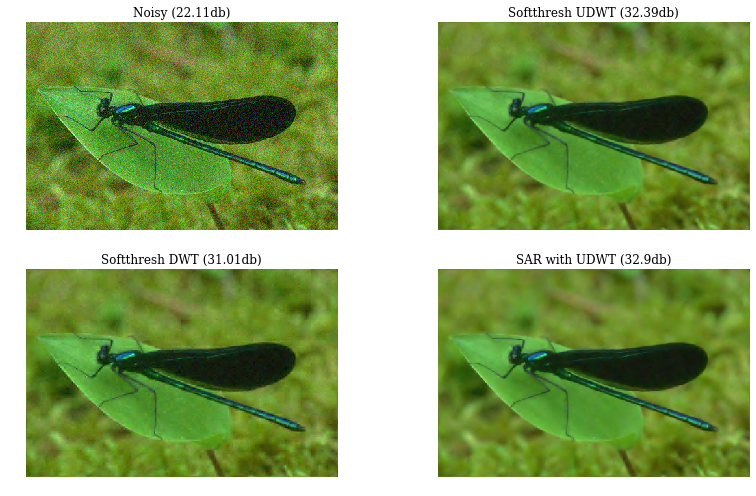

In [38]:
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(15,7))
im.show(ydragonfly,ax=axes[0][0])
axes[0][0].set_title("Noisy ({}db)".format(np.round(im.psnr(clean,ydragonfly),decimals=2)))
im.show(DWT_soft_thresh,ax=axes[1][0])
axes[1][0].set_title("Softthresh DWT ({}db)".format(np.round(im.psnr(clean,DWT_soft_thresh),decimals=2)))
im.show(UDWT_soft_thresh,ax=axes[0][1])
axes[0][1].set_title("Softthresh UDWT ({}db)".format(np.round(im.psnr(clean,UDWT_soft_thresh),decimals=2)))
im.show(UDWT_SAR_dragonfly,ax=axes[1][1])
axes[1][1].set_title("SAR with UDWT ({}db)".format(np.round(im.psnr(clean,UDWT_SAR_dragonfly),decimals=2)))

## 24

In [39]:
clean = im.dwt_crop(plt.imread("assets/topgun.png"),J)
W = im.DWT(clean.shape,J)
sig = 2 / 255
motion_blur = im.Convolution(clean.shape,im.kernel("motion"))
yblurry = motion_blur(clean) + sig * np.random.randn(*clean.shape)

DWT_SAR = sparse_analysis_regularization(yblurry, sig, W,H=motion_blur,gamma=100)

In [40]:
clean = im.dwt_crop(plt.imread("assets/topgun.png"),J)
W = im.UDWT(clean.shape,J)
sig = 2 / 255

UDWT_SAR = sparse_analysis_regularization(yblurry, sig, W,H=motion_blur,gamma=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'SAR with UDWT (27.36db)')

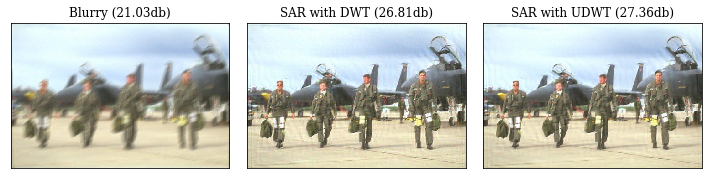

In [41]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,25))
axes[0].imshow(yblurry)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Blurry ({}db)".format(np.round(im.psnr(clean,yblurry),decimals=2)))

axes[1].imshow(DWT_SAR)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("SAR with DWT ({}db)".format(np.round(im.psnr(clean,DWT_SAR),decimals=2)))

axes[2].imshow(UDWT_SAR)
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title("SAR with UDWT ({}db)".format(np.round(im.psnr(clean,UDWT_SAR),decimals=2)))

## 25

In [42]:
#random masking 40%

clean = im.dwt_crop(plt.imread("assets/topgun.png"),J)
sig = 2 / 255
random_masking = im.RandomMasking(clean.shape,0.4)
y = random_masking(clean) + sig * np.random.randn(*clean.shape)

H = im.RandomMasking(y.shape,0.4)

In [43]:
W = im.DWT(clean.shape,J)
DWT_SAR_masking = sparse_analysis_regularization(random_masking(y), sig, W, H=H, gamma=100)

In [44]:
W = im.UDWT(clean.shape,J)
UDWT_SAR_masking = sparse_analysis_regularization(random_masking(y), sig, W, H=H, gamma=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'SAR with UDWT (7.06db)')

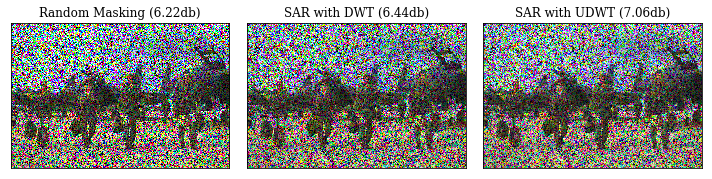

In [45]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,25))
axes[0].imshow(random_masking(y))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Random Masking ({}db)".format(np.round(im.psnr(clean,y),decimals=2)))

axes[1].imshow(DWT_SAR_masking)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("SAR with DWT ({}db)".format(np.round(im.psnr(clean,DWT_SAR_masking),decimals=2)))

axes[2].imshow(UDWT_SAR_masking)
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title("SAR with UDWT ({}db)".format(np.round(im.psnr(clean,UDWT_SAR_masking),decimals=2)))